In [2]:
%load_ext autoreload
%autoreload 2
import glob
from pathlib import Path
import pyedflib
from hmpai.pytorch.generators import MultiNumpyDataset, worker_init_fn
from hmpai.pytorch.pretraining import random_masking
import pandas as pd
import numpy as np
import multiprocessing
import os
from tqdm.notebook import tqdm
import pickle
from hmpai.pytorch.models import *
from hmpai.pytorch.training import train_and_test, pretrain
from sklearn.model_selection import train_test_split
import itertools
import h5py
from scipy import interpolate
import matplotlib.pyplot as plt
from perlin_noise import PerlinNoise
DATA_PATH = Path(os.getenv("DATA_PATH"))

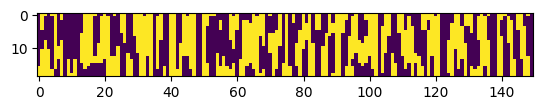

In [85]:
noise = PerlinNoise(octaves=10, seed=1)
def perlin(trial):
    mask = np.array([[noise([i/trial.shape[1], j/trial.shape[0]]) for j in range(trial.shape[1])] for i in range(trial.shape[0])])
    mask = mask > 0
    trial[mask] = 1
    return trial

trial = np.zeros((19, 150))
for i in range(100):
    trial = perlin(trial)
plt.imshow(trial)
plt.show()

In [6]:
n_reps = 10000
n_chs = 19
n_samples = 150  # 150 samples @ 256 Hz = 590ms, originally chosen based on processing operation duration
def show_trial(trial, mean, std, ax):
    ax.set_title(f"Mean removed: {mean:.4f}, std: {std:.4f}, n = {n_reps}")
    ax.imshow(trial, cmap="Greys")
    ax.set_xlabel("Samples (time)")
    ax.set_ylabel("Channels")
    # plt.show()


def find_continuous_ones(mask):
    # Find the lengths of continuous sequences of 1's in a binary mask
    lengths = []
    current_length = 0

    for value in mask:
        if value == 1:
            current_length += 1
        else:
            if current_length > 0:
                lengths.append(current_length)
                current_length = 0

    # Append the last length if the mask ends with a sequence of 1's
    if current_length > 0:
        lengths.append(current_length)

    return lengths


def calc_and_show_stats(method):
    ratios = np.empty((n_reps))
    masks = np.empty((n_reps, n_chs, n_samples))
    all_lengths = []

    for i in range(n_reps):
        trial = np.zeros((n_chs, n_samples))
        masked = method(trial)
        masks[i, :] = masked
        ratios[i] = masked.sum() / masked.size
        for channel in range(n_chs):
            channel_mask = masked[channel]
            ones_lengths = find_continuous_ones(channel_mask)
            all_lengths.extend(ones_lengths)
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.hist(all_lengths, bins=30, edgecolor="black")
    ax1.set_xlabel("Length of mask")
    ax1.set_xlim(0, 151)
    ax1.set_ylabel("Frequency")
    ax1.set_title(f"Lengths of masked out subsequences (n = {n_reps})")
    show_trial(masked, ratios.mean(), ratios.std(), ax=ax2)
    plt.show()

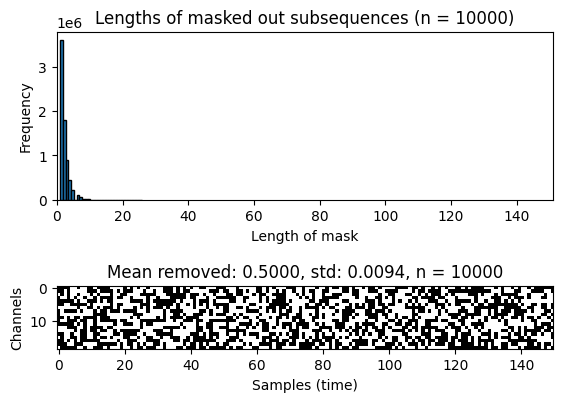

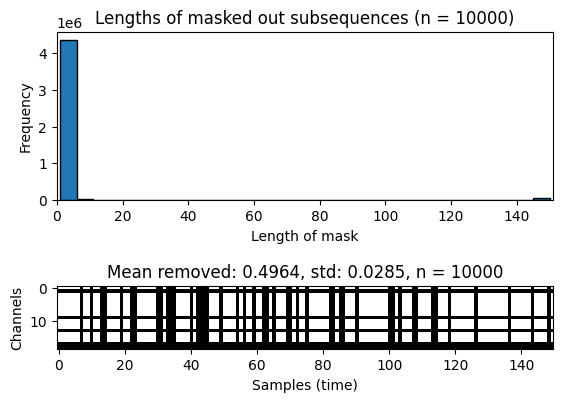

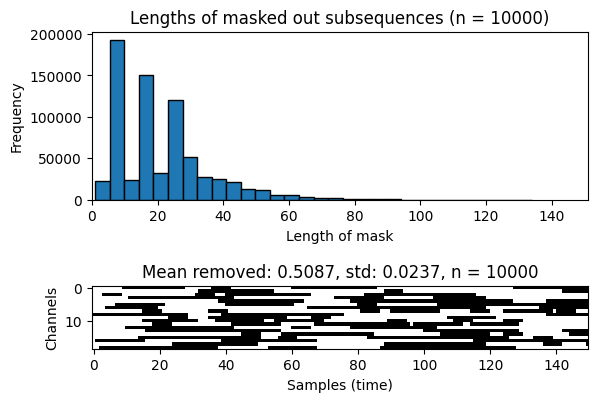

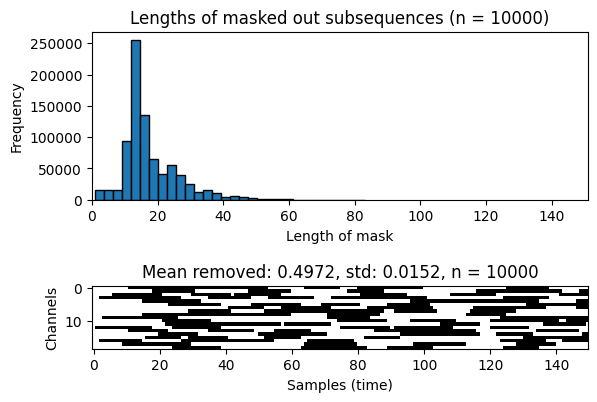

In [23]:
# Look at timescales of different wave oscillations, ERPs, (2 oscillations for Nyquist)
# Plot binarization of different choices
# Plot histogram of subsequence lengths
n_reps = 10000
n_chs = 19
n_samples = 150  # 150 samples @ 256 Hz = 590ms, originally chosen based on processing operation duration
trial = np.zeros((n_chs, n_samples))

# Randomly remove 50%
def rand50(trial):
    mask = np.random.rand(19, 150) > 0.5
    trial[mask] = 1
    return trial


calc_and_show_stats(rand50)


# Remove entire channels/electrodes
# 36% resulted in closest to 50% total removal
def remove_lines(trial):
    chs_remove = np.random.randint(0, n_chs, (int(0.36 * n_chs)))
    samples_remove = np.random.randint(0, n_samples, (int(0.36 * n_samples)))
    trial[chs_remove, :] = 1
    trial[:, samples_remove] = 1

    return trial


calc_and_show_stats(remove_lines)


def oscillation_based(trial):
    # Middles of frequency bands (Alpha, Beta, Gamma), translated to samples for 256 Hz
    obj_lengths = [6, 15, 26]
    # 7 resulted in nearest to 50 removal ratio
    n_subsequences = 7

    # Loop over each channel
    for channel in range(trial.shape[0]):
        lengths = np.random.choice(obj_lengths, n_subsequences, replace=True)
        starting_points = np.random.randint(0, trial.shape[1], n_subsequences)

        # Remove or mask subsequences per channel
        for start, length in zip(starting_points, lengths):
            end = min(start + length, trial.shape[1])
            trial[channel, start:end] = (
                1  # Replace with zeros (or any other masking value)
            )

    return trial


calc_and_show_stats(oscillation_based)


def hmp_based(trial):
    # Gives closest to 50% removal
    n_subsequences = 8

    # Loop over each channel
    for channel in range(trial.shape[0]):
        # Between 11 and 15(incl) sample duration, sometimes overlap
        lengths = np.random.randint(11, 16, n_subsequences)
        # lengths = np.random.choice(obj_lengths, n_subsequences, replace=True)
        starting_points = np.random.randint(0, trial.shape[1], n_subsequences)

        # Remove or mask subsequences per channel
        for start, length in zip(starting_points, lengths):
            end = min(start + length, trial.shape[1])
            trial[channel, start:end] = (
                1  # Replace with zeros (or any other masking value)
            )

    return trial


calc_and_show_stats(hmp_based)

noise = PerlinNoise(octaves=10, seed=1)


def perlin(trial):
    mask = np.array(
        [
            [
                noise([i / trial.shape[1], j / trial.shape[0]])
                for j in range(trial.shape[1])
            ]
            for i in range(trial.shape[0])
        ]
    )
    mask = mask > 0
    trial[mask] = 1
    return trial


# Nevermind, takes much too long, if we would do it per-channel it would take 19 times longer even
# calc_and_show_stats(perlin)

def random_ext(trial):
    # trial (19, 150)
    # 150/30 = 5 min length

    mask = np.random.randint(0, 1, (trial.shape[0], 30))
    mask = np.repeat(mask, 5, axis=1)
    trial = trial * mask
    return trial

calc_and_show_stats(random_ext)


In [10]:
np.random.randint(0, 2, (10, 10)).repeat(5, axis=1)

array([[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

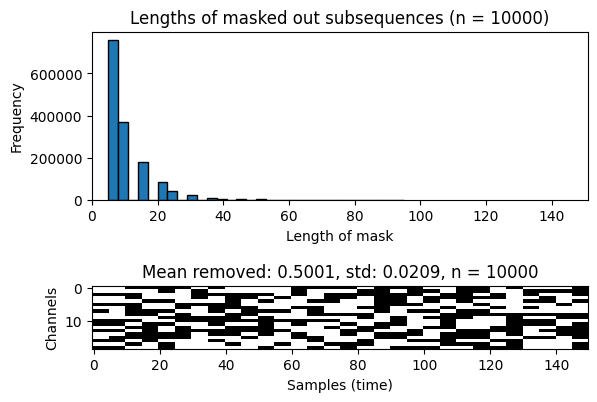

In [11]:
def random_ext(trial):
    # trial (19, 150)
    # 150/30 = 5 min length

    mask = np.random.randint(0, 2, (trial.shape[0], 30))
    mask = np.repeat(mask, 5, axis=1)
    return mask

calc_and_show_stats(random_ext)